In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
import h5py
import sys
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.lines import Line2D
import copy 

sys.path.append("../../unfolding/")
from functions_folding import *

In [2]:
def color_HF(ax, d_CC, d_HFs, alpha, min_x=None, max_x=None):
    if min_x == None:
        bins = np.arange(np.min(d_CC),np.max(d_CC),0.01)
    else:
        bins = np.arange(min_x,max_x,0.01)
    val = np.interp(bins, d_CC, d_HFs)
    for i in range(len(bins)):
        if val[i] > 1.5:
            ax.axvspan(bins[i],bins[i] + 0.01, facecolor="turquoise", alpha=alpha)
        else:
            ax.axvspan(bins[i],bins[i] + 0.01, facecolor="pink", alpha=alpha)
    return ax

In [3]:
def load_h5(filename):
    hf = h5py.File(filename, 'r')
    d_CC = np.array(hf.get("d_CC"))
    E_init = np.array(hf.get("E_init"))
    E_final = np.array(hf.get("E_final"))
    functional = np.array(hf.get("functional"))
    basis_set = np.array(hf.get("basis_set"))
    geometries = np.array(hf.get("geometries"))
    hf.close()
    return d_CC, E_init, E_final, geometries

In [4]:
def distance_angle(geometries):
    coordinates = geometries[:,1]
    vec_a_1 = np.cross(coordinates[:,3] - coordinates[:,9], coordinates[:,6] - coordinates[:,9])

    vec_a_2 = coordinates[:,11] - coordinates[:,9]
    
    vec_b_1 = np.cross(coordinates[:,9] - coordinates[:,3], coordinates[:,1] - coordinates[:,3])
    vec_b_2 = coordinates[:,5] - coordinates[:,3]
    
    d = np.linalg.norm(coordinates[:,9] - coordinates[:,3])

    d_HC = np.linalg.norm(coordinates[:,5] - coordinates[:,3],axis=1)
    d_FC = np.linalg.norm(coordinates[:,11] - coordinates[:,9],axis=1)
    d_HF = np.linalg.norm(coordinates[:,11] - coordinates[:,5],axis=1)
    d_HF2 = np.linalg.norm(coordinates[:,11] - coordinates[:,4],axis=1)
    d_CH4 = np.zeros(len(d_HF))
    d_CH4_2 = np.zeros(len(d_HF))
    arg_H = np.zeros(len(d_HF),dtype=int)
    for i in range(len(d_CH4)):
        if d_HF[i] > d_HF2[i]:
            atom = 4
            atom_2 = 5
        else:
            atom = 5
            atom_2 = 4
        arg_H[i] = atom
        #print("BIG MISTAKE MORRON!!!")
        #tmp = coordinates[:,3][i] - coordinates[:,argmin[i]+4][i]
        tmp = coordinates[i,3] - coordinates[i,atom]
        tmp_2 = coordinates[i,3] - coordinates[i,atom_2]
        d_CH4[i] = np.linalg.norm(tmp)
        d_CH4_2[i] = np.linalg.norm(tmp_2)
        

    CCF = angle_vec(vec_a_1,vec_a_2)
    CCH = angle_vec(vec_b_1, vec_b_2)
    
    return CCF, CCH, d_HC, d_FC, np.minimum(d_HF, d_HF2), np.vstack([d_CH4, d_CH4_2, arg_H])

In [5]:
def load_filtered(d_filter, file):
    d_CC, E_init, E_final, geometries = load_h5(file)
    CCF, CCH, d_HCs, d_FCs, d_HFs, argmin = distance_angle(geometries)
    d, id1, id2 = np.intersect1d(d_CC, d_filter, return_indices=True)
    d_CC, E_init, E_final, CCF, CCH, d_HCs, d_FCs, d_HFs, geometries, argmin = d_CC[id1], E_init[id1], E_final[id1], CCF[id1], CCH[id1], d_HCs[id1], d_FCs[id1], d_HFs[id1], geometries[id1], np.vstack([argmin[0][id1],argmin[1][id1],argmin[2][id1]])
    ### removed the calculations where CCSD has failed ###
    mask = np.where(E_final != 0)[0]
    #mask2 = np.where(E_final[mask] != 0)[0]
    return d_CC[mask], E_init[mask], E_final[mask], CCF[mask], CCH[mask], d_HCs[mask], d_FCs[mask], d_HFs[mask], geometries[mask], np.vstack([argmin[0][mask],argmin[1][mask]])

In [6]:
def load_unfiltered(file):
    d_CC, E_init, E_final, geometries = load_h5(file)
    CCF, CCH, d_HCs, d_FCs, d_HFs, argmin = distance_angle(geometries)
    return d_CC, E_init, E_final, CCF, CCH, d_HCs, d_FCs, d_HFs, geometries, argmin

In [7]:
def legend_without_duplicate_labels(ax,loc="best",fontsize=10):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc=loc,fontsize=fontsize)

In [8]:
def dihedral(geometry,argmin=None):
    graph = np.array([[4,5,0], [11,6,10]])
    
    center = np.array([[3,3,3],[9,9,9]])
    R, D =  split_norm(geometry[graph] - geometry[center])
    D_left, R_left = np.roll(D, 1, axis = -2), np.roll(R, 1, axis = -1)
    D_right, R_right = np.roll(D, -1, axis = -2), np.roll(R, -1, axis = -1)
    
    ### Unit vector perpendicular to nj and mj ###
    u = np.cross( - D_right, D_left, axis = -1)
    u = u / np.linalg.norm(u,axis=-1)[...,NA]
    
    ### Projection of jk on the njm plane as the second axis###
    w = D - u * np.sum(D * u, axis =-1)[...,NA]
    w = w / np.linalg.norm(w, axis=-1)[...,NA] 
    
    ### Complete the local coordinate system with a vector orthogonal to both u and w ###
    v = np.cross(w, u, axis = -1)
    v = v / np.linalg.norm(v, axis=-1)[...,NA]
    
    ### In order to place the phantom atom i we need to define the value f  which determines the proportion along nm at which i lies###
    f = np.sum(- D_right * v, axis = -1) / ( np.sum(- D_right * v, axis = -1) + np.sum( D_left * v, axis = -1) )
    
    rji = D_left + (1 - f)[...,NA] * (D_right - D_left)
    R_ji, D_ji = split_norm(rji)
    cos_gamma = np.sum(D_ji * D, axis=-1)
    dihedral_angles = np.rad2deg(np.arccos(cos_gamma))

    if argmin != None:
        if argmin == 5:
            a , b = copy.deepcopy(dihedral_angles[0][0]), copy.deepcopy(dihedral_angles[0][1])
            dihedral_angles[0][0], dihedral_angles[0][1] = b, a
    return dihedral_angles

In [9]:
def plot_molecule(fig, ax, geometry, point, init=False):
    ax = fig.gca(projection='3d')
    # Plot the furthest optimised geometry
    X = geometry[point,-1]
    print(X.shape)
    c = ["r","b","b","r","b","b","r","b","b","r","b","gold"]
    labels = ["Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Fluroine"]

    for i in range(len(X)):
        ax.scatter(X[i,0], X[i,1], X[i,2], color=c[i], s=200.0, label=labels[i])

    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #if init == True:
    #    ax.view_init(elev=20., azim=-45)
    ax._axis3don = False

    for a,b in zip([0,0,0,3,3,6,6,6,9,9],[1,2,3,4,5,7,8,9,10,11]):
        line = np.vstack([X[a],X[b]]).T
        ax.plot(line[0],line[1],line[2], color="k")
    
    if init == True:
        legend_without_duplicate_labels(ax)
        
    return ax

In [10]:
def plt_energies(E_final_b3lyp, d_CC_b3lyp, d_HFs_b3lyp, ax, fig, functional,fontsize=18):
    # Plot final CCSD energies ###
    ax.plot(d_CC_b3lyp, E_final_b3lyp, color="k", marker="o", label = functional)

    ### Fit polynomial to the start where no HF is formed ###
    x1, y1 = d_CC_b3lyp[np.where(d_HFs_b3lyp > 1.5)], E_final_b3lyp[np.where(d_HFs_b3lyp > 1.5)]
    z1 = np.polyfit(x1, y1, 2)
    p1 = np.poly1d(z1)
    x_val1 = np.linspace(1.9,2.5,100)
    y_val1 = p1(x_val1)

    ### Fit polynomial to the start where no HF is formed ###
    x2, y2 = d_CC_b3lyp[np.where(d_HFs_b3lyp < 1.5)], E_final_b3lyp[np.where(d_HFs_b3lyp < 1.5)]
    z2 = np.polyfit(x2, y2, 4)
    p2 = np.poly1d(z2)
    x_val2 = np.linspace(1.2,2.2,100)
    y_val2 = p2(x_val2)

    ### Plot the two harmonic fits ###
    ax.plot(x_val1, y_val1, color="blue", linestyle="dashed", label="Quadratic Fit without HF formation")
    ax.plot(x_val2, y_val2, color="red", linestyle="dashed", label="Quartic Fit with HF formation")


    # Color the background where the H-F has been formed 
    min_x, max_x = np.min(d_CC_b3lyp), np.max(d_CC_b3lyp)
    ax = color_HF(ax, d_CC_b3lyp, d_HFs_b3lyp, alpha=1, min_x=min_x, max_x=max_x)


    handles, labels = ax.get_legend_handles_labels()
    legend_elements = [Line2D([0], [0], color="turquoise", lw=4, label='No HF formation'),
                        Line2D([0], [0], color="pink", lw=4, label='HF formation')]

    legend1 = ax.legend(fontsize=fontsize,loc='lower right')
    ax.add_artist(legend1)
    legend2 = ax.legend(handles=legend_elements,loc="upper left",fontsize=fontsize)
    
    roots = p2.deriv().roots[np.isreal(p2.deriv().roots)]
    closest_der = np.argmin(roots - 1.46)
    min_dist = roots[closest_der]
    E_min = np.real(p2(min_dist))
    p3 = p1 - p2
    
    roots = np.array(p3.roots[np.isreal(p3.roots)])
    if len(roots) > 1:
        print(roots)
        closest_root = np.argmin(np.abs(roots - 2.064))
        intersection = np.real(roots[closest_root])
    else: 
        intersection = np.real(roots)
    
    t = ax.text(0.02, 0.58, 'Optimal distance: %.3f [$\AA$] \nIntersection:  %.3f [$\AA$]' %(min_dist, intersection), transform=ax.transAxes, fontsize=fontsize)
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))
    
    return ax, fig, np.real(min_dist), np.real(intersection), np.real(E_min)

In [11]:
def no(data,point):
    return np.hstack([data[:point],data[point+1:]])

In [12]:
d_CC, E_init, E_final, geometries_CC = load_h5("../../data/linesearch/CCSD.h5")
CCF, CCH, d_HCs, d_FCs, d_HFs, argmin_CC = distance_angle(geometries_CC)
### removed the calculations where CCSD has failed ###
mask = np.where(E_final != 0)[0]
d_CC, E_init, E_final, CCF, CCH, d_HCs, d_FCs, d_HFs, geometries_CC, argmin_CC  = d_CC[mask], E_init[mask], E_final[mask], CCF[mask], CCH[mask], d_HCs[mask], d_FCs[mask], d_HFs[mask], geometries_CC[mask], np.vstack([argmin_CC[0][mask],argmin_CC[1][mask],argmin_CC[2][mask]])

d_CC_b3lyp, E_init_b3lyp, E_final_b3lyp, CCF_b3lyp, CCH_b3lyp, d_HCs_b3lyp, d_FCs_b3lyp, d_HFs_b3lyp, geo_b3lyp, argmin_b3lyp  = load_filtered(d_CC, "../../data/linesearch/b3lyp_no_dispersion.h5")
d_CC_b3lyp_ed, E_init_b3lyp_ed, E_final_b3lyp_ed, CCF_b3lyp_ed, CCH_b3lyp_ed, d_HCs_b3lyp_ed, d_FCs_b3lyp_ed, d_HFs_b3lyp_ed, geo_b3lyp_ed,argmin_b3lyp_ed  = load_filtered(d_CC, "../../data/linesearch/b3lyp_dispersion.h5")

d_CC_cam_b3lyp, E_init_cam_b3lyp, E_final_cam_b3lyp, CCF_cam_b3lyp, CCH_cam_b3lyp, d_HCs_cam_b3lyp, d_FCs_cam_b3lyp, d_HFs_cam_b3lyp, geo_cam_b3lyp, argmin_cam_b3lyp  = load_filtered(d_CC, "../../data/linesearch/cam_b3lyp_no_dispersion.h5")
d_CC_cam_b3lyp_ed, E_init_cam_b3lyp_ed, E_final_cam_b3lyp_ed, CCF_cam_b3lyp_ed, CCH_cam_b3lyp_ed, d_HCs_cam_b3lyp_ed, d_FCs_cam_b3lyp_ed, d_HFs_cam_b3lyp_ed, geo_cam_b3lyp_ed,argmin_cam_b3lyp_ed  = load_filtered(d_CC, "../../data/linesearch/cam_b3lyp_dispersion.h5")

d_CC_m062x, E_init_m062x, E_final_m062x, CCF_m062x, CCH_m062x, d_HCs_m062x, d_FCs_m062x, d_HFs_m062x,geo_m062x, argmin_m062x = load_filtered(d_CC, "../../data/linesearch/m062x_no_dispersion.h5")
d_CC_m062x_ed, E_init_m062x_ed, E_final_m062x_ed, CCF_m062x_ed, CCH_m062x_ed, d_HCs_m062x_ed, d_FCs_m062x_ed, d_HFs_m062x_ed, geo_m062x_ed, argmin_m062x_ed = load_filtered(d_CC, "../../data/linesearch/m062x_dispersion.h5")

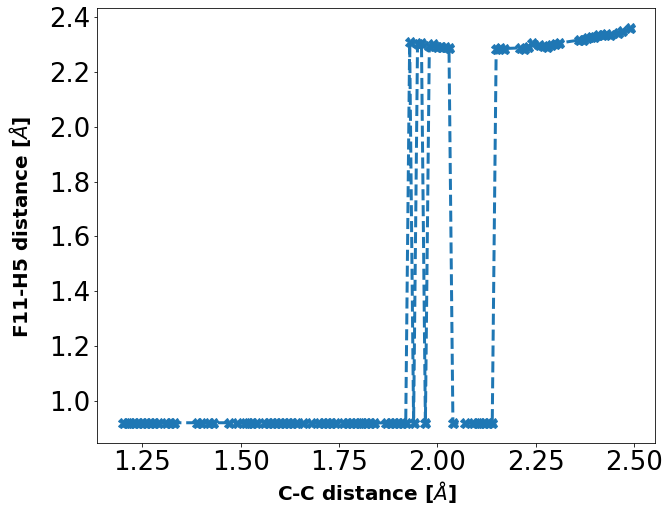

In [13]:
#%matplotlib notebook

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(d_CC, d_HFs, label="CCSD caclulations", marker="X",markersize=10,linewidth=3,linestyle='dashed')

# Set legend
fig.text(0.018, 0.5, 'F11-H5 distance [$\AA$]',fontweight='bold',  ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.04, 'C-C distance [$\AA$]', fontweight='bold',ha='center', va='center',fontsize=20);
ax.tick_params(axis='both', which='major', labelsize=26)

#fig.savefig("../../Illustrations/HF_dist.pdf")

(12, 3)


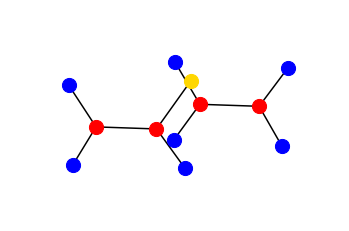

In [14]:
fig = plt.figure()
#ax = fig.gca(projection='3d')

# Plot the furthest optimised geometry
X = geometries_CC[-1,-1]
c = ["r","b","b","r","b","b","r","b","b","r","b","gold"]
labels = ["Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Fluroine"]

#for i in range(len(X)):
#    ax.scatter(X[i,0],X[i,1],X[i,2], color=c[i], s=100.0, label=labels[i])

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
#ax.view_init(elev=20., azim=-45)
#ax._axis3don = False
plot_molecule(fig, ax, geometries_CC, point=-1)

#for a,b in zip([0,0,0,3,3,6,6,6,9,9],[1,2,3,4,5,7,8,9,10,11]):
#    line = np.vstack([X[a],X[b]]).T
#    ax.plot(line[0],line[1],line[2], color="k")

legend_without_duplicate_labels(ax,loc="lower right")
#fig.savefig("../../Illustrations/LS_init.png", transparent="True")

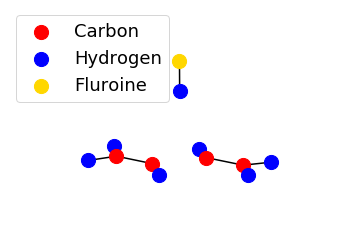

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the furthest optimised geometry
#X = geometries_CC[39,-1]

X = geo_b3lyp[-25,-1]
c = ["r","b","b","r","b","b","r","b","b","r","b","gold"]
labels = ["Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Hydrogen","Carbon","Hydrogen","Fluroine"]

for i in range(len(X)):
    ax.scatter(X[i,0],X[i,1],X[i,2], color=c[i], s=200.0, label=labels[i])

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-25)
ax._axis3don = False

for a,b in zip([0,0,0,3,6,6,6,9,11],[1,2,3,4,7,8,9,10,5]):
    line = np.vstack([X[a],X[b]]).T
    ax.plot(line[0],line[1],line[2], color="k")

legend_without_duplicate_labels(ax,loc="upper left",fontsize=18)
#fig.savefig("../../Illustrations/LS_mid.png", transparent="True")

(12, 3)
(12, 3)
1.97


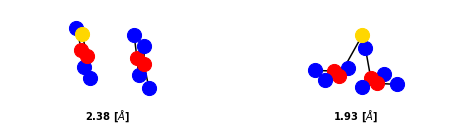

In [16]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.view_init(elev=20., azim=15)
plot_molecule(fig, ax, geometries_CC, point=-10, init=False)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.view_init(elev=20., azim=15)
plot_molecule(fig, ax, geometries_CC, point=40, init=False)

fig.text(0.3, 0.5, '2.38 [$\AA$]', fontweight='bold',ha='center', va='center');
fig.text(0.73, 0.5, '1.93 [$\AA$]', fontweight='bold',ha='center', va='center');

#fig.savefig("two_molecules.pdf")
#print(d_HFs[51:60])
#print(d_HFs[58])
print(d_CC[58])

Text(0.06, 0.5, 'Minimal F-H distance [$\\AA$]')

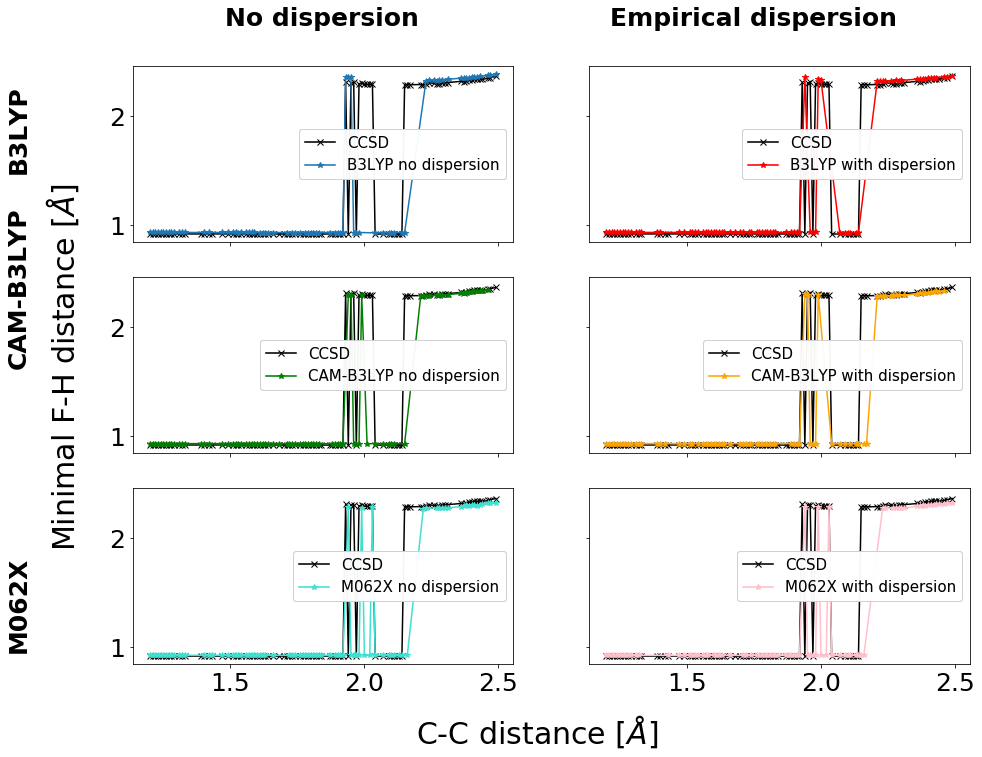

In [17]:
fig, ax = plt.subplots(3,2,figsize=(15,11),sharex='all', sharey='all')

ax[0,0].plot(d_CC, d_HFs, marker="x", color="black", label ="CCSD")
ax[0,0].plot(no(d_CC_b3lyp,15), no(d_HFs_b3lyp,15), label="B3LYP no dispersion", marker="*")
ax[0,0].tick_params(axis='both', which='major', labelsize=25)

legend = ax[0,0].legend(fontsize=15,loc="center right")
ax[0,0].add_artist(legend)

ax[0,1].plot(d_CC, d_HFs, label="CCSD", marker="x", color="black")
ax[0,1].plot(no(d_CC_b3lyp_ed,15), no(d_HFs_b3lyp_ed,15), label="B3LYP with dispersion", marker="*", color = "red")
ax[0,1].tick_params(axis='both', which='major', labelsize=25)

legend = ax[0,1].legend(fontsize=15,loc="center right")
ax[0,1].add_artist(legend)

ax[1,0].plot(d_CC, d_HFs, label="CCSD", marker="x", color="black")
ax[1,0].plot(no(d_CC_cam_b3lyp,16), no(d_HFs_cam_b3lyp,16), label="CAM-B3LYP no dispersion", marker="*", color = "green")
ax[1,0].tick_params(axis='both', which='major', labelsize=25)

legend = ax[1,0].legend(fontsize=15,loc="center right")
ax[1,0].add_artist(legend)

ax[1,1].plot(d_CC, d_HFs, label="CCSD", marker="x", color="black")
ax[1,1].plot(d_CC_cam_b3lyp_ed, d_HFs_cam_b3lyp_ed, label="CAM-B3LYP with dispersion", marker="*", color = "orange")
ax[1,1].tick_params(axis='both', which='major', labelsize=25)

legend = ax[1,1].legend(fontsize=15,loc="center right")
ax[1,1].add_artist(legend)

ax[2,0].plot(d_CC, d_HFs, label="CCSD", marker="x", color="black")
ax[2,0].plot(d_CC_m062x, d_HFs_m062x, label="M062X no dispersion", marker="*", color = "turquoise")
ax[2,0].tick_params(axis='both', which='major', labelsize=25)

legend = ax[2,0].legend(fontsize=15,loc="center right")
ax[2,0].add_artist(legend)

ax[2,1].plot(d_CC, d_HFs, label="CCSD", marker="x", color="black")
ax[2,1].plot(d_CC_m062x_ed, d_HFs_m062x_ed, label="M062X with dispersion", marker="*", color = "pink")
ax[2,1].tick_params(axis='both', which='major', labelsize=25)

legend = ax[2,1].legend(fontsize=15,loc="center right")
ax[2,1].add_artist(legend)

# Set legend
fig.text(0.3, 0.94, 'No dispersion',fontweight='bold',  ha='center', va='center',fontsize=25)
fig.text(0.7, 0.94, 'Empirical dispersion', fontweight='bold', ha='center', va='center',fontsize=25)
fig.text(0.02, 0.2, 'M062X', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.02, 0.6, 'CAM-B3LYP', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.02, 0.8, 'B3LYP', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=25)

# Set labels 
fig.text(0.5, 0.04, 'C-C distance [$\AA$]', ha='center', va='center',fontsize=30)
fig.text(0.06, 0.5, 'Minimal F-H distance [$\AA$]', ha='center', va='center', rotation='vertical',fontsize=30)

#fig.savefig("../../Illustrations/Functionals_FH.pdf")


In [18]:
E0 = np.array([E_final[-1], E_final_b3lyp[-1], E_final_b3lyp_ed[-1], E_final_cam_b3lyp[-1], E_final_cam_b3lyp_ed[-1], E_final_m062x[-1], E_final_m062x_ed[-1]])
E2 = np.array([E_final[40], E_final_b3lyp[33], E_final_b3lyp_ed[36], E_final_cam_b3lyp[37], E_final_cam_b3lyp_ed[34], E_final_m062x[35], E_final_m062x_ed[32]])
E1 = np.array([E_final[39], E_final_b3lyp[32], E_final_b3lyp_ed[35], E_final_cam_b3lyp[36], E_final_cam_b3lyp_ed[33], E_final_m062x[34], E_final_m062x_ed[31]])
#E_min = np.array([E_min_CC,  E_min_b3lyp,  E_min_b3lyp_ed, E_min_cam_b3lyp , E_min_cam_b3lyp_ed,  E_min_m062x, E_min_m062x_ed])

In [19]:
dE = E1 - E0
#dE_1 = E1- E0 
#dE_CC, dE_b3lyp, dE_b3lyp_ed, dE_cam_b3lyp, dE_cam_b3lyp_ed, dE_m062x, dE_m062x_ed = (E1 - E0)

In [20]:
'''
fig, ax = plt.subplots(figsize=(8,10))
phi = np.linspace(0, 2*np.pi, len(dE))
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1.+np.cos(phi          )), # scaled to [0,1]
    .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

plt.xticks(rotation=30)
label = ["B3LYP", "B3LYP-GD3", "CAM-B3LYP", "CAM-B3LYP-GD3", "M062X", "M062X-GD3"]

#Enthalpie from last points
#ax.scatter(label, dE[1:], color=rgb_cycle[1:], marker = "o", s=130)
#ax.axhline(dE[0], color="green")

#Enthalpie from energy minimum derived by plot 
ax.scatter(label, dE_1[1:], color=rgb_cycle[1:], marker = "x", s=130)
ax.axhline(dE_1[0], color="orange")

fig.text(0.45, 0.58 ,"CCSD", color="orange",fontsize=20)
fig.text(0.02, 0.5, 'Energy barrier [au]',fontweight='bold', ha='center', va='center', rotation='vertical')
#fig.savefig("dE_HF.pdf")
'''

'\nfig, ax = plt.subplots(figsize=(8,10))\nphi = np.linspace(0, 2*np.pi, len(dE))\nrgb_cycle = np.vstack((            # Three sinusoids\n    .5*(1.+np.cos(phi          )), # scaled to [0,1]\n    .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.\n    .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)\n\nplt.xticks(rotation=30)\nlabel = ["B3LYP", "B3LYP-GD3", "CAM-B3LYP", "CAM-B3LYP-GD3", "M062X", "M062X-GD3"]\n\n#Enthalpie from last points\n#ax.scatter(label, dE[1:], color=rgb_cycle[1:], marker = "o", s=130)\n#ax.axhline(dE[0], color="green")\n\n#Enthalpie from energy minimum derived by plot \nax.scatter(label, dE_1[1:], color=rgb_cycle[1:], marker = "x", s=130)\nax.axhline(dE_1[0], color="orange")\n\nfig.text(0.45, 0.58 ,"CCSD", color="orange",fontsize=20)\nfig.text(0.02, 0.5, \'Energy barrier [au]\',fontweight=\'bold\', ha=\'center\', va=\'center\', rotation=\'vertical\')\n#fig.savefig("dE_HF.pdf")\n'

In [21]:
d_HF_init = np.linalg.norm(geometries_CC[:,0,11] - geometries_CC[:,0,5],axis=1)

In [22]:
def get_distances(geometries):
    distances  = np.zeros([geometries.shape[0], 4])
    directions = np.zeros([geometries.shape[0],4, 3])
    for i in range(geometries.shape[0]):
        ### take the final geometry ###
        geometry = geometries[i,1]
        R, D  = split_norm(np.array([geometry[3] - geometry[4], geometry[3] - geometry[5], geometry[9] - geometry[10], geometry[9] - geometry[11]]))
        distances[i], directions[i] = R, D
    return distances, directions

In [23]:
R_CH, D_CH = get_distances(geometries_CC)
R_b3lyp, D_b3lyp = get_distances(geo_b3lyp)
R_b3lyp_ed, D_b3lyp_ed = get_distances(geo_b3lyp_ed)
R_cam_b3lyp, D_cam_b3lyp = get_distances(geo_cam_b3lyp)
R_cam_b3lyp_ed, D_cam_b3lyp_ed = get_distances(geo_cam_b3lyp_ed)
R_m062x, D_m062x = get_distances(geo_m062x)
R_m062x_ed, D_m062x_ed = get_distances(geo_m062x_ed)

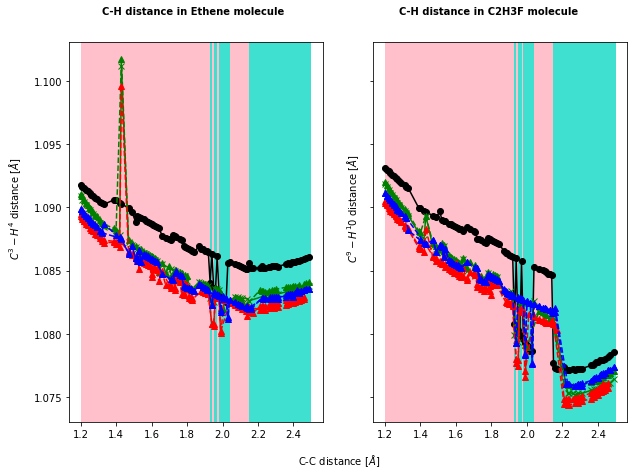

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,7), sharex='all', sharey='all')
### Set labels and stuff ###
fig.text(0.3, 0.94, 'C-H distance in Ethene molecule ',fontweight='bold',  ha='center', va='center')
fig.text(0.71, 0.94, 'C-H distance in C2H3F molecule ',fontweight='bold',  ha='center', va='center')
fig.text(0.05, 0.55, '$C^3-H^4$ distance $[\AA]$', ha='center', va='center', rotation='vertical')
fig.text(0.52, 0.55, '$C^9-H^10$ distance $[\AA]$', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'C-C distance $[\AA]$', ha='center', va='center')

### Color the background where the HF has been formed ###
ax[0] = color_HF(ax[0], d_CC, d_HFs, alpha=1)
ax[1] = color_HF(ax[1], d_CC, d_HFs, alpha=1)

### Plot the CH distances ### 
ax[0].plot(d_CC, R_CH[:,0], color="k", marker ="o")
ax[1].plot(d_CC, R_CH[:,2], color="k", marker ="o")

ax[0].plot(d_CC_b3lyp, R_b3lyp[:,0], color="g", marker="x", label="B3LYP")
ax[1].plot(d_CC_b3lyp, R_b3lyp[:,2], color="g", marker="x", label="B3LYP")

ax[0].plot(d_CC_b3lyp_ed, R_b3lyp_ed[:,0], color="g", marker="^", label="B3LYP-GD3", linestyle="dashed")
ax[1].plot(d_CC_b3lyp_ed, R_b3lyp_ed[:,2], color="g", marker="^", label="B3LYP-GD3", linestyle="dashed")

ax[0].plot(d_CC_cam_b3lyp, R_cam_b3lyp[:,0], color="r", marker="^", label="CAM-B3LYP", linestyle="dashed")
ax[1].plot(d_CC_cam_b3lyp, R_cam_b3lyp[:,2], color="r", marker="^", label="CAM-B3LYP", linestyle="dashed")

ax[0].plot(d_CC_cam_b3lyp_ed, R_cam_b3lyp_ed[:,0], color="r", marker="^", label="CAM-B3LYP-GD3", linestyle="dashed")
ax[1].plot(d_CC_cam_b3lyp_ed, R_cam_b3lyp_ed[:,2], color="r", marker="^", label="CAM-B3LYP-GD3", linestyle="dashed")

ax[0].plot(d_CC_m062x, R_m062x[:,0], color="b", marker="^", label="M062X", linestyle="dashed")
ax[1].plot(d_CC_m062x, R_m062x[:,2], color="b", marker="^", label="M062X", linestyle="dashed")

ax[0].plot(d_CC_m062x_ed, R_m062x_ed[:,0], color="b", marker="^", label="M062X", linestyle="dashed")
ax[1].plot(d_CC_m062x_ed, R_m062x_ed[:,2], color="b", marker="^", label="M062X", linestyle="dashed")

#fig.savefig("d_CH.pdf")

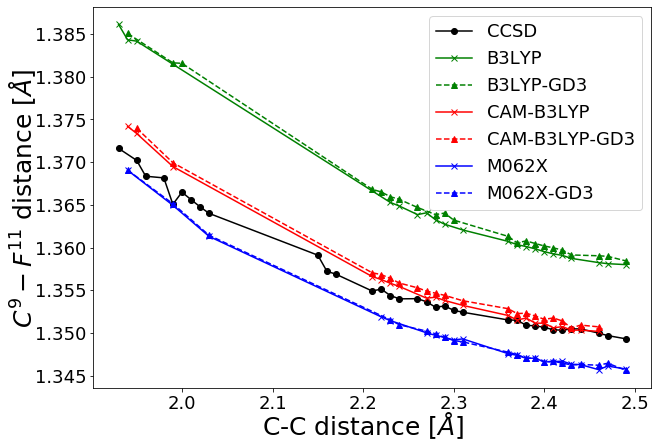

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,7), sharex='all', sharey='all')
### Set labels and stuff ###
#fig.text(0.3, 0.94, 'CCSD',fontweight='bold',  ha='center', va='center')
#fig.text(0.71, 0.94, 'M062X' ,fontweight='bold',  ha='center', va='center')
fig.text(0.027, 0.5, '$C^9-F^{11}$ distance $[\AA]$', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.5, 0.05, 'C-C distance $[\AA]$', ha='center', va='center',fontsize=25)


### Define a filter, where the HF is not formed ### 
f_HF = np.where(d_HFs > 1.5)[0]

### Plot the CH distances ### 
ax.plot(d_CC[f_HF], R_CH[f_HF][:,3], color="k", marker="o", label = "CCSD")

ax.plot(d_CC_b3lyp[np.where(d_HFs_b3lyp > 1.5)[0]][1:], R_b3lyp[np.where(d_HFs_b3lyp > 1.5)[0]][1:][:,3], color="g", marker="x", label="B3LYP")
ax.plot(d_CC_b3lyp_ed[np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:], R_b3lyp_ed[np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:][:,3], color="g", marker="^", label="B3LYP-GD3", linestyle="dashed")

ax.plot(d_CC_cam_b3lyp[np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], R_cam_b3lyp[np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:][:,3], color="r", marker="x", label="CAM-B3LYP")
ax.plot(d_CC_cam_b3lyp_ed[np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]][1:], R_cam_b3lyp_ed[np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]][1:][:,3], color="r", marker="^", label="CAM-B3LYP-GD3", linestyle="dashed")

ax.plot(d_CC_m062x[np.where(d_HFs_m062x > 1.5)[0]], R_m062x[np.where(d_HFs_m062x > 1.5)[0]][:,3], color="b", marker="x", label="M062X")
ax.plot(d_CC_m062x_ed[np.where(d_HFs_m062x_ed > 1.5)[0]], R_m062x_ed[np.where(d_HFs_m062x_ed > 1.5)[0]][:,3], color="b", marker="^", label="M062X-GD3", linestyle="dashed")

min_x, max_x = np.min(d_CC[f_HF]), np.max(d_CC[f_HF])
#ax = color_HF(ax, d_CC, d_HFs, alpha=1, min_x=min_x, max_x=max_x)

handles, labels = ax.get_legend_handles_labels()
legend_elements = [Line2D([0], [0], color="turquoise", lw=4, label='No HF formation'),
                    Line2D([0], [0], color="pink", lw=4, label='HF formation')]

### Fit polynomial to the start where no HF is formed ###
x1, y1 = d_CC[f_HF], R_CH[f_HF][:,3]
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
x_val1 = np.linspace(1.9,2.5,100)
y_val1 = p1(x_val1)
#ax.plot(x_val1, y_val1, color="purple",label="Polynomial Fit for HF-bond stretching")

legend1 = ax.legend(fontsize=18)
ax.tick_params(labelsize=18)
#ax.add_artist(legend1)
#legend2 = ax.legend(handles=legend_elements,loc="upper center")
#fig.savefig("../../Illustrations/C-F_dist.pdf")
#print( R_CH[f_HF][:,3][-1])
#print(np.min(R_CH[f_HF][:,3]) -np.max(R_CH[f_HF][:,3]))

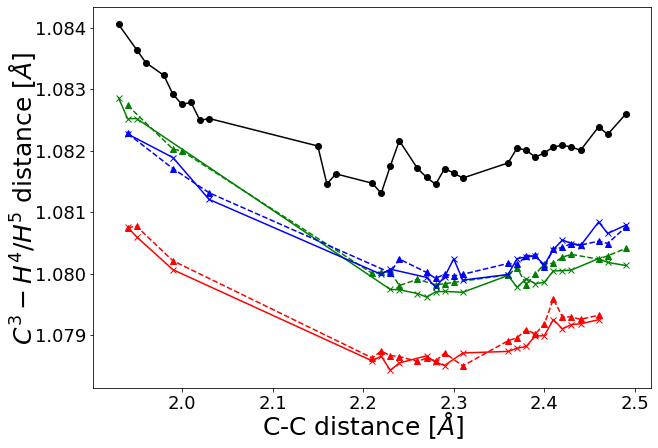

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,7), sharex='all', sharey='all')
### Set labels and stuff ###
fig.text(0.027, 0.5, '$C^3-H^{4}/H^{5}$ distance $[\AA]$', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.5, 0.05, 'C-C distance $[\AA]$', ha='center', va='center',fontsize=25)


### Define a filter, where the HF is not formed ### 
f_HF = np.where(d_HFs > 1.5)[0]

### Plot the CH distances ### 
ax.plot(d_CC[f_HF], argmin_CC[0,f_HF], color="k", marker="o", label = "CCSD")
#ax.plot(d_CC[f_HF], argmin_CC[1,f_HF], color="r", marker="o", label = "CCSD")


ax.plot(d_CC_b3lyp[np.where(d_HFs_b3lyp > 1.5)[0]][1:], argmin_b3lyp[0][np.where(d_HFs_b3lyp > 1.5)[0]][1:], color="g", marker="x", label = "B3LYP")
ax.plot(d_CC_b3lyp_ed[np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:], argmin_b3lyp_ed[0][np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:],color="g", marker="^", label="B3LYP-GD3", linestyle="dashed")

ax.plot(d_CC_cam_b3lyp[np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], argmin_cam_b3lyp[0][np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], color="r", marker="x", label = "CAM-B3LYP")
ax.plot(d_CC_cam_b3lyp_ed[np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]], argmin_cam_b3lyp_ed[0][np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]],color="r", marker="^", label="CAM-B3LYP-GD3", linestyle="dashed")

ax.plot(d_CC_m062x[np.where(d_HFs_m062x > 1.5)[0]], argmin_m062x[0][np.where(d_HFs_m062x > 1.5)[0]], color="b", marker="x", label = "M062X")
ax.plot(d_CC_m062x_ed[np.where(d_HFs_m062x_ed > 1.5)[0]], argmin_m062x_ed[0][np.where(d_HFs_m062x_ed > 1.5)[0]],color="b", marker="^", label="M062X-GD3", linestyle="dashed")

#handles, labels = ax.get_legend_handles_labels()
#legend_elements = [Line2D([0], [0], color="turquoise", lw=4, label='No HF formation'),
#                    Line2D([0], [0], color="pink", lw=4, label='HF formation')]

#legend1 = ax.legend(fontsize=15,loc=(0.16,.01))
ax.tick_params(labelsize=18)
#ax.add_artist(legend1)
#legend2 = ax.legend(handles=legend_elements,loc="upper center")
#fig.savefig("../../Illustrations/C-H_dist.pdf")
#print(argmin_CC[0,f_HF][-1])
#print(np.min(argmin_CC[0,f_HF]) -np.max(argmin_CC[0,f_HF]))

In [27]:
dihedrals_CC = np.zeros([geometries_CC.shape[0],2,3])

dihedrals_b3lyp = np.zeros([geo_b3lyp.shape[0],2,3])
dihedrals_b3lyp_ed = np.zeros([geo_b3lyp_ed.shape[0],2,3])
dihedrals_cam_b3lyp = np.zeros([geo_cam_b3lyp.shape[0],2,3])
dihedrals_cam_b3lyp_ed = np.zeros([geo_cam_b3lyp_ed.shape[0],2,3])
dihedrals_m062x = np.zeros([geo_m062x.shape[0],2,3])
dihedrals_m062x_ed = np.zeros([geo_m062x_ed.shape[0],2,3])

for i in range(geometries_CC.shape[0]):
    angles = dihedral(geometries_CC[i,-1], argmin_CC[-1,i])
    dihedrals_CC[i] = angles
    
for i in range(geo_b3lyp.shape[0]):
    angles = dihedral(geo_b3lyp[i,-1], argmin_b3lyp[-1,i])
    dihedrals_b3lyp[i] = angles
for i in range(geo_b3lyp_ed.shape[0]):
    angles = dihedral(geo_b3lyp_ed[i,-1], argmin_b3lyp_ed[-1,i])
    dihedrals_b3lyp_ed[i] = angles
for i in range(geo_cam_b3lyp.shape[0]):
    angles = dihedral(geo_cam_b3lyp[i,-1], argmin_cam_b3lyp[-1,i])
    dihedrals_cam_b3lyp[i] = angles
for i in range(geo_cam_b3lyp_ed.shape[0]):
    angles = dihedral(geo_cam_b3lyp_ed[i,-1], argmin_cam_b3lyp_ed[-1,i])
    dihedrals_cam_b3lyp_ed[i] = angles
for i in range(geo_m062x.shape[0]):
    angles = dihedral(geo_m062x[i,-1],argmin_m062x[-1,i])
    dihedrals_m062x[i] = angles
for i in range(geo_m062x_ed.shape[0]):
    angles = dihedral(geo_m062x_ed[i,-1],argmin_m062x_ed[-1,i])
    dihedrals_m062x_ed[i] = angles



In [28]:
dihedrals_CC.shape

(98, 2, 3)

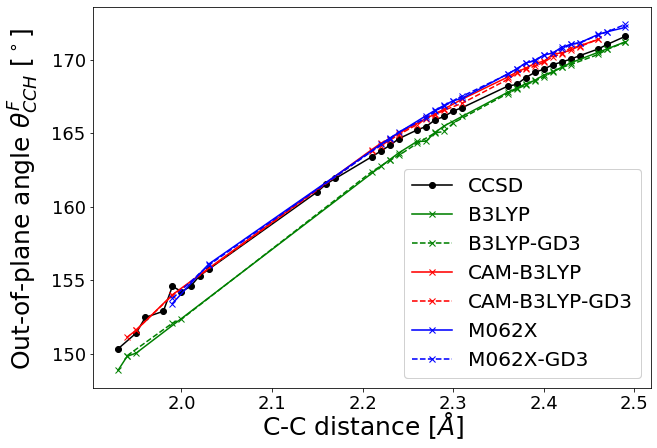

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,7), sharex='all', sharey='all')
### Set labels and stuff ###
#fig.text(0.3, 0.94, 'CCSD',fontweight='bold',  ha='center', va='center')
#fig.text(0.71, 0.94, 'M062X' ,fontweight='bold',  ha='center', va='center')
fig.text(0.03, 0.5, 'Out-of-plane angle $\\theta^{F}_{CCH}$ [$^\circ$]', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.5, 0.05, 'C-C distance [$\AA$]', ha='center', va='center',fontsize=25)


### Define a filter, where the HF is not formed ### 
f_HF = np.where(d_HFs > 1.5)[0]

### Plot the CH distances ### 
ax.plot(d_CC[f_HF],dihedrals_CC[:,0,0][f_HF], color="k", marker="o", label = "CCSD")

ax.plot(d_CC_b3lyp[np.where(d_HFs_b3lyp > 1.5)[0]][1:], dihedrals_b3lyp[:,0,0][np.where(d_HFs_b3lyp > 1.5)[0]][1:], color="g", marker="x", label="B3LYP")
ax.plot(d_CC_b3lyp_ed[np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:], dihedrals_b3lyp_ed[:,0,0][np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:], color="g", marker="x", label="B3LYP-GD3",linestyle="dashed")

ax.plot(d_CC_cam_b3lyp[np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], dihedrals_cam_b3lyp[:,0,0][np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], color="r", marker="x", label="CAM-B3LYP")
ax.plot(d_CC_cam_b3lyp_ed[np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]][1:], dihedrals_cam_b3lyp_ed[:,0,0][np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]][1:], color="r", marker="x", label="CAM-B3LYP-GD3",linestyle="dashed")

ax.plot(d_CC_m062x[np.where(d_HFs_m062x > 1.5)[0]][1:], dihedrals_m062x[:,0,0][np.where(d_HFs_m062x > 1.5)[0]][1:], color="b", marker="x", label="M062X")
ax.plot(d_CC_m062x_ed[np.where(d_HFs_m062x_ed > 1.5)[0]][1:], dihedrals_m062x_ed[:,0,0][np.where(d_HFs_m062x_ed > 1.5)[0]][1:], color="b", marker="x", label="M062X-GD3",linestyle="dashed")

#min_x, max_x = np.min(d_CC[f_HF]), np.max(d_CC[f_HF])
#ax = color_HF(ax, d_CC, d_HFs, alpha=1, min_x=min_x, max_x=max_x)

legend1 = ax.legend(fontsize=20)
ax.add_artist(legend1)
ax.tick_params(labelsize=18)

#fig.savefig("../../Illustrations/dih_F.pdf")

[1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29 1.31 1.32 1.33 1.39
 1.4  1.42 1.43 1.47 1.49 1.51 1.52 1.53 1.54 1.56 1.57 1.58 1.59 1.6
 1.61 1.62 1.63 1.64 1.66 1.68 1.7  1.71 1.72 1.73 1.74 1.76 1.77 1.78
 1.79 1.8  1.81 1.82 1.83 1.84 1.87 1.88 1.89 1.9  1.91 1.92 1.94 1.97
 2.04 2.07 2.09 2.1  2.11 2.12 2.13 2.14]


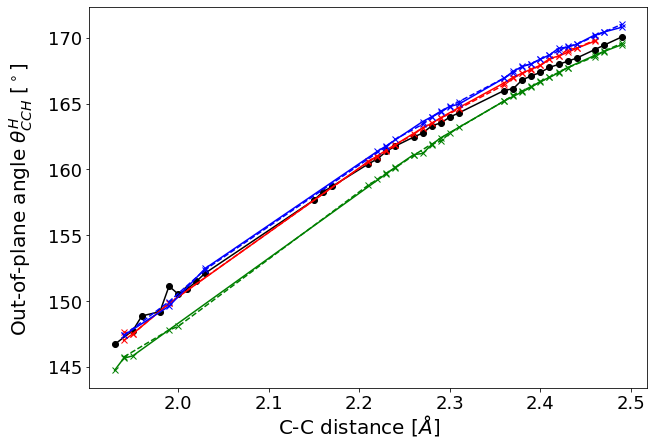

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,7), sharex='all', sharey='all')
### Set labels and stuff ###
#fig.text(0.3, 0.94, 'CCSD',fontweight='bold',  ha='center', va='center')
#fig.text(0.71, 0.94, 'M062X' ,fontweight='bold',  ha='center', va='center')
fig.text(0.03, 0.5, 'Out-of-plane angle $\\theta^{H}_{CCH}$ [$^\circ$]', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.05, 'C-C distance [$\AA$]', ha='center', va='center',fontsize=20)


### Define a filter, where the HF is not formed ### 
f_HF = np.where(d_HFs > 1.5)[0]

### Plot the CH distances ### 
ax.plot(d_CC[f_HF],dihedrals_CC[:,1,0][f_HF], color="k", marker="o", label = "CCSD")

ax.plot(d_CC_b3lyp[np.where(d_HFs_b3lyp > 1.5)[0]][1:], dihedrals_b3lyp[:,1,0][np.where(d_HFs_b3lyp > 1.5)[0]][1:], color="g", marker="x", label="B3LYP")
ax.plot(d_CC_b3lyp_ed[np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:], dihedrals_b3lyp_ed[:,1,0][np.where(d_HFs_b3lyp_ed > 1.5)[0]][1:], color="g", marker="x", label="B3LYP-GD3",linestyle="dashed")

ax.plot(d_CC_cam_b3lyp[np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], dihedrals_cam_b3lyp[:,1,0][np.where(d_HFs_cam_b3lyp > 1.5)[0]][1:], color="r", marker="x", label="CAM-B3LYP")
ax.plot(d_CC_cam_b3lyp_ed[np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]], dihedrals_cam_b3lyp_ed[:,1,0][np.where(d_HFs_cam_b3lyp_ed > 1.5)[0]], color="r", marker="x", label="CAM-B3LYP-GD3",linestyle="dashed")

ax.plot(d_CC_m062x[np.where(d_HFs_m062x > 1.5)[0]], dihedrals_m062x[:,1,0][np.where(d_HFs_m062x > 1.5)[0]], color="b", marker="x", label="M062X")
ax.plot(d_CC_m062x_ed[np.where(d_HFs_m062x_ed > 1.5)[0]], dihedrals_m062x_ed[:,1,0][np.where(d_HFs_m062x_ed > 1.5)[0]], color="b", marker="x", label="M062X-GD3",linestyle="dashed")

#min_x, max_x = np.min(d_CC[f_HF]), np.max(d_CC[f_HF])
#ax = color_HF(ax, d_CC, d_HFs, alpha=1, min_x=min_x, max_x=max_x)

#legend1 = ax.legend(fontsize=20)
#ax.add_artist(legend1)
ax.tick_params(labelsize=18)

#fig.savefig("../../Illustrations/dih_H.pdf")

print(d_CC[np.where(d_HFs < 1.5)[0]])

In [31]:
dihedrals_m062x[:,1,0][np.where(d_HFs_m062x > 1.5)[0]] - dihedrals_m062x[:,0,0][np.where(d_HFs_m062x > 1.5)[0]]

array([-3.75779857, -3.78445408, -3.59488301, -2.85798637, -2.86400019,
       -2.55155496, -2.55341118, -2.46586868, -2.42385556, -2.40696586,
       -2.08937902, -1.91483656, -1.95067254, -1.91376601, -1.92685797,
       -1.76432656, -1.65240596, -1.75521521, -1.65407623, -1.50337142,
       -1.47182374, -1.39215278])

[2.07555668+0.j 0.94711565+0.j]


/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: ComplexWarning: Casting complex values to real discards the imaginary part


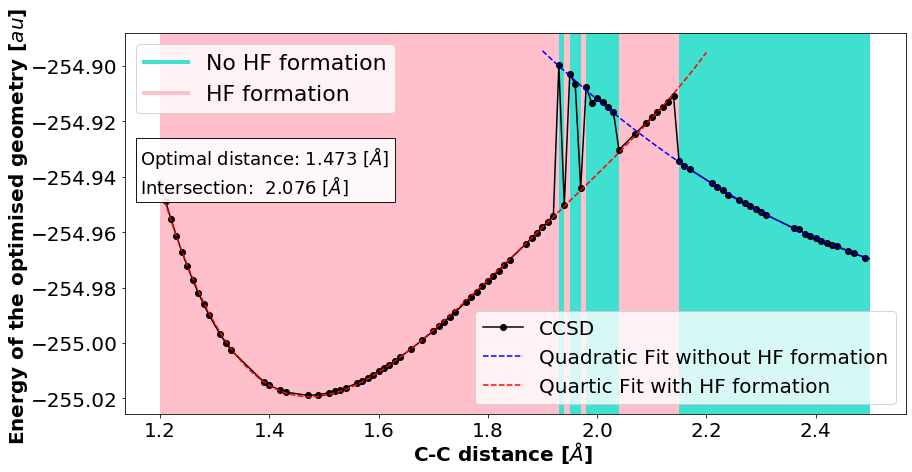

In [32]:
fig, ax = plt.subplots(1,1,figsize=(14,7), sharex='all', sharey='all')

# Axes labels 
fig.text(0.02, 0.5, 'Energy of the optimised geometry [$au$]', ha='center', va='center', rotation='vertical',fontweight='bold',fontsize=20)
fig.text(0.5, 0.05, 'C-C distance [$\AA$]', ha='center', va='center',fontweight='bold',fontsize=20)

# Plot final CCSD energies ###
ax.plot(d_CC,E_final, color="k", marker="o", label = "CCSD")

### Fit polynomial to the start where no HF is formed ###
x1, y1 = d_CC[np.where(d_HFs > 1.5)], E_final[np.where(d_HFs > 1.5)]
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
x_val1 = np.linspace(1.9,2.5,100)
y_val1 = p1(x_val1)

### Fit polynomial to the start where no HF is formed ###
x2, y2 = d_CC[np.where(d_HFs < 1.5)], E_final[np.where(d_HFs < 1.5)]
z2 = np.polyfit(x2, y2, 4)
p2 = np.poly1d(z2)
x_val2 = np.linspace(1.2,2.2,100)
y_val2 = p2(x_val2)
### Plot the two harmonic fits ###
ax.plot(x_val1, y_val1, color="blue", linestyle="dashed", label="Quadratic Fit without HF formation")
ax.plot(x_val2, y_val2, color="red", linestyle="dashed", label="Quartic Fit with HF formation")
ax.tick_params(axis='both', which='major', labelsize=20)


# Color the background where the H-F has been formed 
min_x, max_x = np.min(d_CC), np.max(d_CC)
ax = color_HF(ax, d_CC, d_HFs, alpha=1, min_x=min_x, max_x=max_x)


handles, labels = ax.get_legend_handles_labels()
legend_elements = [Line2D([0], [0], color="turquoise", lw=4, label='No HF formation'),
                    Line2D([0], [0], color="pink", lw=4, label='HF formation')]

legend1 = ax.legend(fontsize=20)
ax.add_artist(legend1)
legend2 = ax.legend(handles=legend_elements,loc="upper left",fontsize=22)

#min_dist = np.real(p2.deriv().roots[2])
#E_min = p2(min_dist)
#p3 = p1 - p2
#intersection = np.real(p3.roots[2])

roots = p2.deriv().roots[np.isreal(p2.deriv().roots)]
closest_der = np.argmin(roots - 1.46)
min_dist = roots[closest_der]
E_min = np.real(p2(min_dist))
p3 = p1 - p2
roots = np.array(p3.roots[np.isreal(p3.roots)])

if len(roots) > 1:
    print(roots)
    closest_root = np.argmin(np.abs(roots - 2.064))
    intersection = np.real(roots[closest_root])
else: 
    intersection = np.real(roots)

    
t = ax.text(0.02, 0.58, 'Optimal distance: %.3f [$\AA$] \nIntersection:  %.3f [$\AA$]' %(min_dist, intersection), transform=ax.transAxes, fontsize=18)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))


#fig.savefig("../../Illustrations/E_final_CC.pdf")

In [33]:
p2_prime = p2.deriv()
p2_prime.roots[np.isreal(p2_prime.roots)]

array([1.47342608+0.j])

[2.07555668+0.j 0.94711565+0.j]


/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


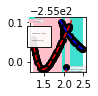

In [34]:
fig,ax = plt.subplots(figsize=(1,1))
_,_, dmin_CC, inter_CC, E_min_CC = plt_energies(E_final, d_CC, d_HFs, ax, fig, "CCSD",fontsize=1)

[2.06486303+0.j 1.02225313+0.j]


/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


[2.06361555+0.j 1.0198561 +0.j]
[2.05227353+0.j 0.98560599+0.j]
[2.05023858+0.j 0.99048642+0.j]
[2.04874014+0.j 0.9972922 +0.j]
[2.04855343+0.j 1.00014013+0.j]


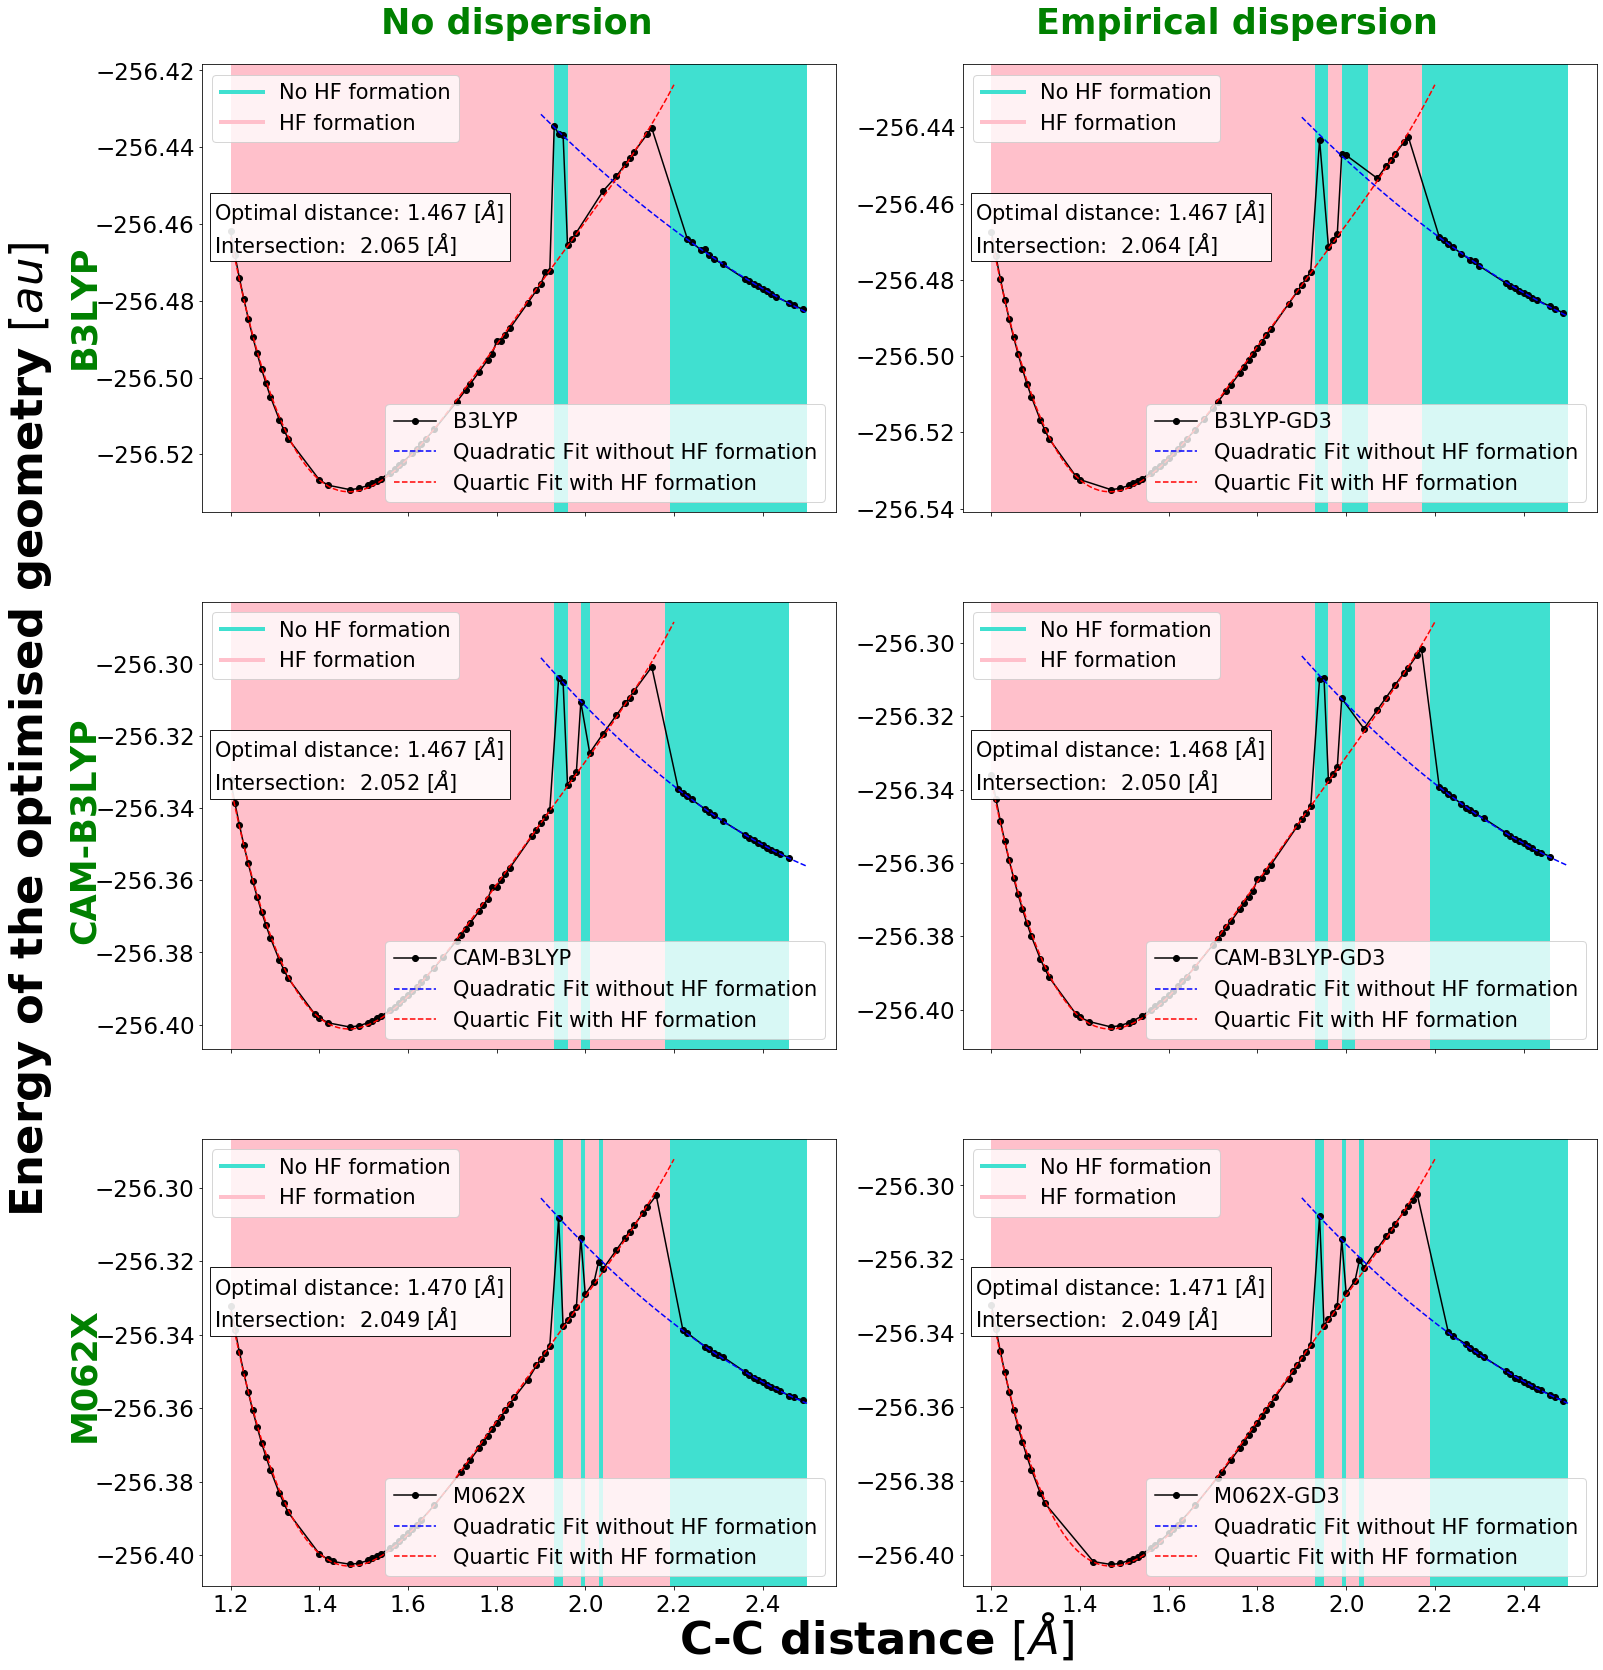

In [35]:
fig, ax = plt.subplots(3,2,figsize=(25,28), sharex='all')

# Axes labels 
fig.text(0.03, 0.55, 'Energy of the optimised geometry $[au]$', ha='center', va='center', rotation='vertical',fontsize=45,fontweight='bold')
fig.text(0.5, 0.1, 'C-C distance $[\AA]$', ha='center', va='center', fontsize=45,fontweight='bold')
fig.text(0.3, 0.9, 'No dispersion',fontweight='bold',  ha='center', va='center',fontsize=35, color="green")
fig.text(0.7, 0.9, 'Empirical dispersion', fontweight='bold', ha='center', va='center',fontsize=35,color="green")

fig.text(0.06, 0.23, 'M062X', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=35, color="green")
fig.text(0.06, 0.5, 'CAM-B3LYP', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=35, color="green")
fig.text(0.06, 0.76, 'B3LYP', fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=35, color="green")

_,_, dmin_b3lyp, inter_b3lyp, E_min_b3lyp = plt_energies(no(E_final_b3lyp,15), no(d_CC_b3lyp,15), no(d_HFs_b3lyp,15), ax[0,0], fig, "B3LYP",fontsize=21)
_,_, dmin_b3lyp_ed, inter_b3lyp_ed, E_min_b3lyp_ed = plt_energies(no(E_final_b3lyp_ed,15), no(d_CC_b3lyp_ed,15), no(d_HFs_b3lyp_ed,15), ax[0,1], fig, "B3LYP-GD3",fontsize=21)

_,_, dmin_cam_b3lyp, inter_cam_b3lyp, E_min_cam_b3lyp = plt_energies(no(E_final_cam_b3lyp,16), no(d_CC_cam_b3lyp,16), no(d_HFs_cam_b3lyp,16), ax[1,0], fig, "CAM-B3LYP",fontsize=21)
_,_, dmin_cam_b3lyp_ed, inter_cam_b3lyp_ed, E_min_cam_b3lyp_ed = plt_energies(E_final_cam_b3lyp_ed, d_CC_cam_b3lyp_ed, d_HFs_cam_b3lyp_ed, ax[1,1], fig, "CAM-B3LYP-GD3",fontsize=21)

_,_, dmin_m062x, inter_m062x, E_min_m062x = plt_energies(E_final_m062x, d_CC_m062x, d_HFs_m062x, ax[2,0], fig, "M062X",fontsize=21)
_,_, dmin_m062x_ed, inter_m062x_ed, E_min_m062x_ed = plt_energies(E_final_m062x_ed, d_CC_m062x_ed, d_HFs_m062x_ed, ax[2,1], fig, "M062X-GD3",fontsize=21)


ax[0,0].tick_params(axis='both', which='major', labelsize=23)
ax[0,1].tick_params(axis='both', which='major', labelsize=23)
ax[1,0].tick_params(axis='both', which='major', labelsize=23)
ax[1,1].tick_params(axis='both', which='major', labelsize=23)
ax[2,0].tick_params(axis='both', which='major', labelsize=23)
ax[2,1].tick_params(axis='both', which='major', labelsize=23)

#fig.savefig("../../Illustrations/E_final_DFT.pdf")

Text(0.016, 0.45, 'C3-C9 distance at optimal 1,3 Butadiene [$\\AA$]')

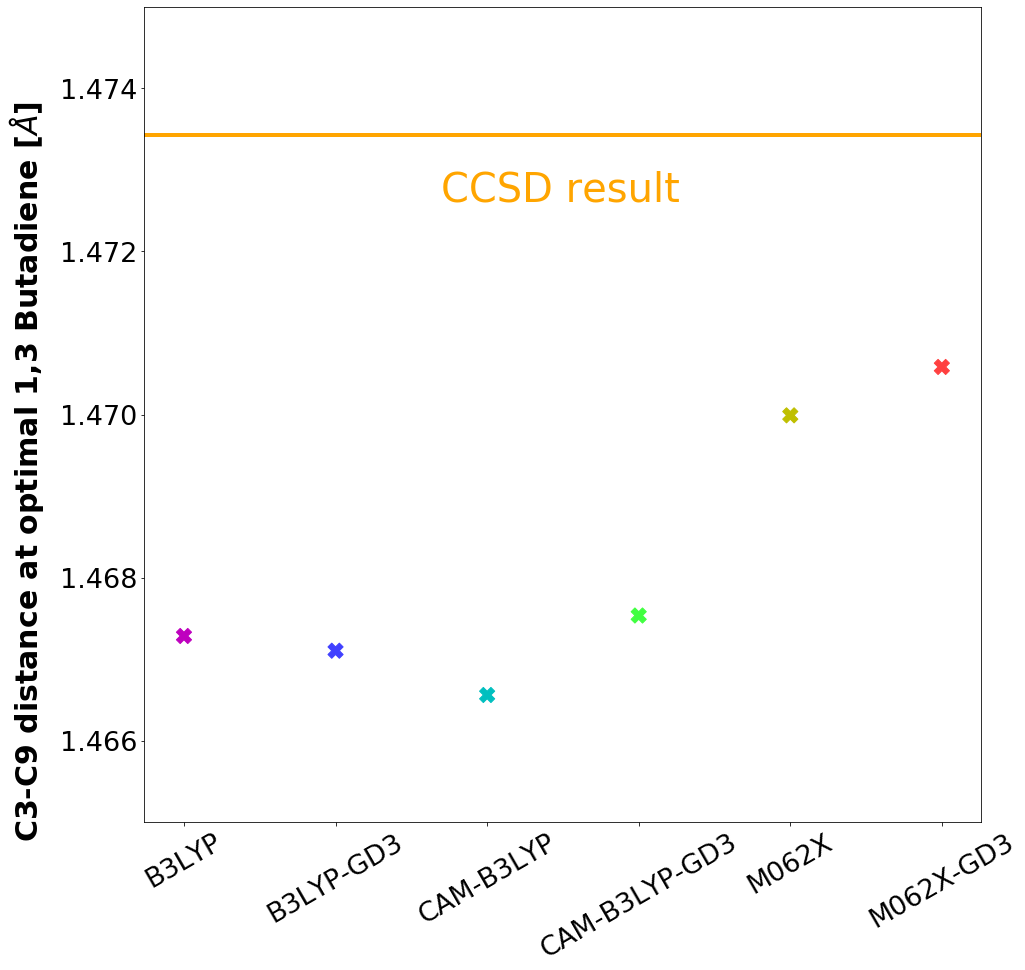

In [36]:
fig, ax = plt.subplots(figsize=(15,15))
dC = [dmin_b3lyp,dmin_b3lyp_ed,dmin_cam_b3lyp,dmin_cam_b3lyp_ed,dmin_m062x,dmin_m062x_ed,dmin_CC]
phi = np.linspace(0, 2*np.pi, len(dE))
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1.+np.cos(phi          )), # scaled to [0,1]
    .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

plt.xticks(rotation=30)
label = ["B3LYP", "B3LYP-GD3", "CAM-B3LYP", "CAM-B3LYP-GD3", "M062X", "M062X-GD3"]
ax.scatter(label, dC[:-1], color=rgb_cycle[1:], marker = "X", s=230)
ax.axhline(dC[-1], color="orange",linewidth=4)
ax.tick_params(axis='both', which='major', labelsize=27)
ax.set_ylim(1.465, 1.475)

fig.text(0.4, 0.7 ,"CCSD result", color="orange", fontsize=40)
fig.text(0.016, 0.45, 'C3-C9 distance at optimal 1,3 Butadiene [$\AA$]',fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=30)
#fig.savefig("../../Illustrations/C-C_dist.pdf")

-0.010693648786142873


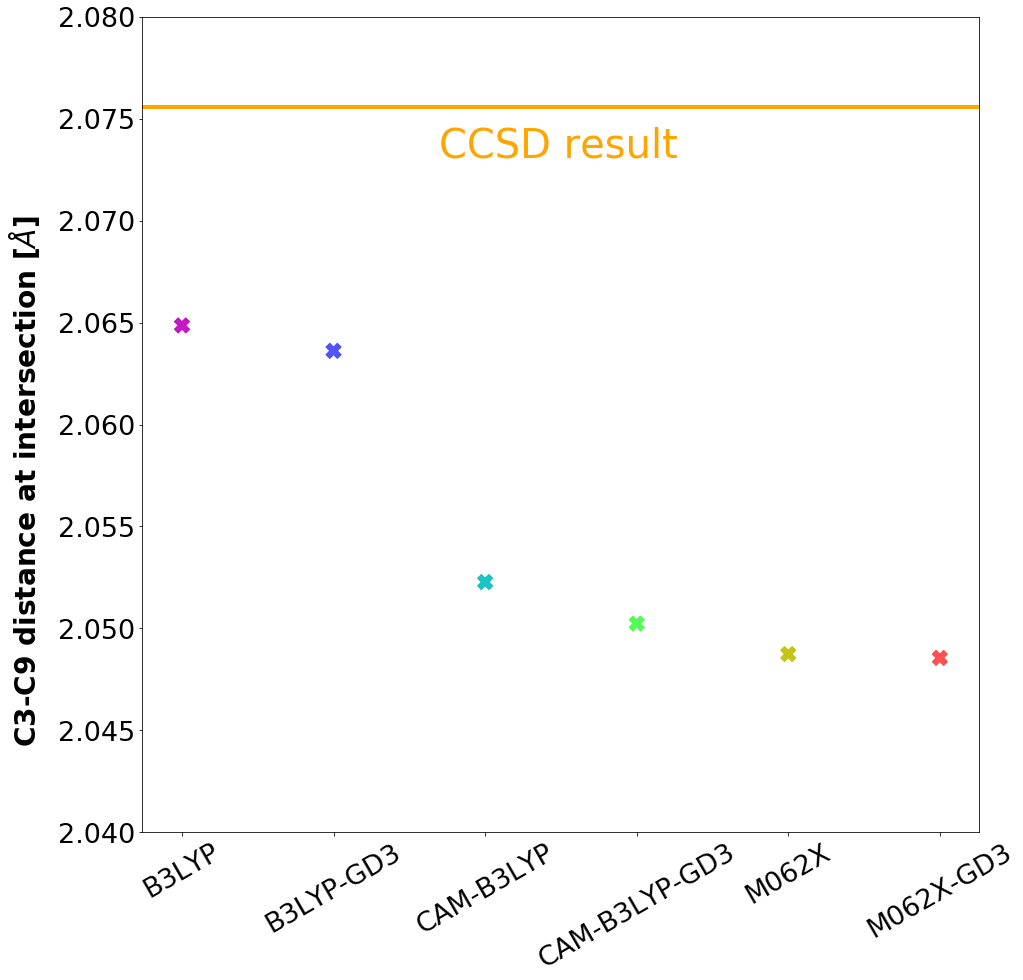

In [37]:
fig, ax = plt.subplots(figsize=(15,15))
capture_dist = [inter_b3lyp,inter_b3lyp_ed,inter_cam_b3lyp,inter_cam_b3lyp_ed,inter_m062x,inter_m062x_ed,inter_CC]
phi = np.linspace(0, 2*np.pi, len(capture_dist))
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1+np.cos(phi          )), # scaled to [0,1]
    .5*(1+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

rgb_cycle = np.hstack([rgb_cycle,np.ones([rgb_cycle.shape[0],1])*0.9])
plt.xticks(rotation=30)
label = ["B3LYP", "B3LYP-GD3", "CAM-B3LYP", "CAM-B3LYP-GD3", "M062X", "M062X-GD3"]
ax.scatter(label, capture_dist[:-1], color=rgb_cycle[1:], marker = "X", s=230)
ax.tick_params(axis='both', which='major', labelsize=27)
ax.axhline(capture_dist[-1], color="orange",linewidth=4)
ax.set_ylim(2.04, 2.08)

fig.text(0.4, 0.75 ,"CCSD result", color="orange", fontsize=40)
fig.text(0.016, 0.45, 'C3-C9 distance at intersection [$\AA$]',fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=28)
#fig.savefig("../../Illustrations/capture_dist.pdf")
print(inter_b3lyp-inter_CC)

In [38]:
E_min = np.array([E_min_CC,  E_min_b3lyp,  E_min_b3lyp_ed, E_min_cam_b3lyp , E_min_cam_b3lyp_ed,  E_min_m062x, E_min_m062x_ed])
E0 = np.array([E_final[-1], E_final_b3lyp[-1], E_final_b3lyp_ed[-1], E_final_cam_b3lyp[-1], E_final_cam_b3lyp_ed[-1], E_final_m062x[-1], E_final_m062x_ed[-1]])
dE_1 = E0 - E_min 

Text(0.016, 0.45, 'Reaction enthalpy [$au$]')

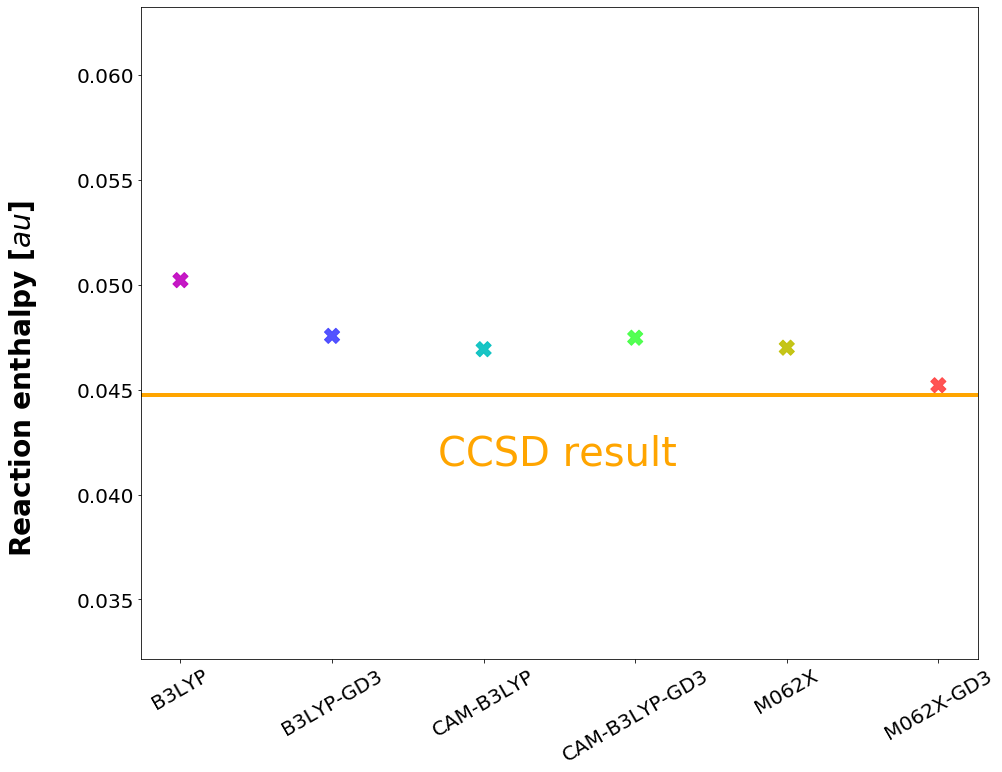

In [39]:
fig, ax = plt.subplots(figsize=(15,12))

phi = np.linspace(0, 2*np.pi, len(dE_1))
rgb_cycle = np.vstack((            # Three sinusoids
    .5*(1+np.cos(phi          )), # scaled to [0,1]
    .5*(1+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
    .5*(1+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)

rgb_cycle = np.hstack([rgb_cycle,np.ones([rgb_cycle.shape[0],1])*0.9])
plt.xticks(rotation=30)
label = ["B3LYP", "B3LYP-GD3", "CAM-B3LYP", "CAM-B3LYP-GD3", "M062X", "M062X-GD3"]
ax.scatter(label, dE_1[:-1], color=rgb_cycle[1:], marker = "X", s=230)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(dE_1[-1], color="orange",linewidth=4)
#ax.set_ylim(2.04, 2.08)

fig.text(0.4, 0.35 ,"CCSD result", color="orange", fontsize=40)
fig.text(0.016, 0.45, 'Reaction enthalpy [$au$]',fontweight='bold', ha='center', va='center', rotation='vertical',fontsize=28)
#fig.savefig("../../Illustrations/E_CC_DFT.pdf")